In [34]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from pandas import Timestamp
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [35]:
pd.reset_option('all')

### Issues with the dataset

A lot of projects, even though they were withdrawn or completed, they do not have the date in which they occured, in fact none of the PJM Projects have completion dates. 

Some projects do not specify the capacity and simply leave it as 0.

A lot of unkown with iso-ne project types.

In [36]:
excel_file = pd.ExcelFile("queues_2023_clean_data.xlsx")
interconnection_data = excel_file.parse("data")


In [37]:
interconnection_data.drop(["q_year", "prop_year"], axis=1, inplace=True)

Transform dates to datetime format

In [38]:


date_columns = ["q_date", "ia_date", "wd_date", "on_date", "prop_date"]
for col in date_columns:
    interconnection_data[col] = pd.to_datetime(
        interconnection_data[col], errors="coerce"
    )


### Helper Functions

We have here a few helper functions that we will need to perform all our calculations 

In [ ]:

renewable = {
    'Solar',
    'Wind',
    'Offshore Wind',
    'Hydro',
    'Biomass',
    'Landfill',
    'Biofuel',
}

non_renewable = {
    'Coal',
    'Gas',
    'Oil',
    'Nuclear',
    'Co-Gen',
    'Steam Turbine',
    'Fuel Cell',
}

storage = {
    'Battery',
    'Pumped Storage',
    'Other Storage',
}

uncategorized = {
    'Other',
    'Unknown',
    float('nan'),  # or `nan` if using NumPy
}

def renewable_split(data):
    """Changes a column into categorical variables"""
    new_df = data.copy()
    for column in ["type1","type2","type3"]:
        categorical = []
        for _, row in data.iterrows():
            item = row[column]
            if item in renewable:
                categorical.append(1)
            elif item in non_renewable:
                categorical.append(2)
            elif item in storage:
                categorical.append(3)
            else:
                categorical.append(0)
        new_df[column] = categorical
    return new_df

def renewable_split(data):
    """
    Converts the 'type1', 'type2', and 'type3' columns of the input DataFrame into
    categorical values:
        1 - Renewable
        2 - Non-renewable
        3 - Storage
        0 - Unknown
    """
    new_df = data.copy()
    for column in ["type1", "type2", "type3"]:
        new_df[column] = data[column].apply(
            lambda x: 1 if x in renewable else
                      2 if x in non_renewable else
                      3 if x in storage else 0
        )
    return new_df


def full_categorical_change(iso):
    encoder = LabelEncoder()

    # Fit the encoder on all unique categories across the three columns
    all_categories = pd.concat([iso['type1'], iso['type2'], iso['type3']]).unique()
    encoder.fit(all_categories)

    # Apply the same encoding to each column
    iso['type1'] = encoder.transform(iso['type1'])
    iso['type2'] = encoder.transform(iso['type2'])
    iso['type3'] = encoder.transform(iso['type3'])



def select_iso(data, *isos):
    "Extracts data from select isos"
    result = []
    for iso in isos:
        result.append(data[data["entity"] == iso])
    result = tuple(result)
    return result


def sort_iso(*isos):
    """Sort ISO by the date they entred the queue"""
    result = []
    for iso in isos:
        sorted_iso = iso.sort_values(by="q_date", ascending=True)
        result.append(sorted_iso)
    result = tuple(result)
    return result


def calculate_difference(df, unit="years"):
    """For projects that have been deployed, calculates
    the time difference between the start date and end date."""

    time_difference = []

    for index, row in df.iterrows():
        delta_days = (row["on_date"] - row["q_date"]).days

        if unit == "years":
            time_difference.append(delta_days / 365.25)
        elif unit == "months":
            time_difference.append(delta_days / 30.44)
        elif unit == "days":
            time_difference.append(float(delta_days))
    return time_difference



def exited_projects(iso):
    completed_projects = iso[iso["on_date"].notna() | iso["wd_date"].notna()]
    project_properties = completed_projects[["on_date","wd_date","type1","type2","type3","mw1","mw2","mw3"]]
    exit_dates = []
    for index, rows in completed_projects.iterrows():
        if pd.isna(rows["on_date"]):
            exit_dates.append(rows["wd_date"])
        else:
            exit_dates.append(rows["on_date"])
    project_properties["exit_date"]=exit_dates
    project_properties.drop(["on_date", "wd_date"], axis=1, inplace=True)
    project_properties = project_properties.fillna(0)
    # full_categorical_change(project_properties)
    # for i in ["type1","type2","type3"]:
    #     categorical_change(project_properties,i)
    project_properties = project_properties.sort_values(by = "exit_date")
    list_of_tuples = list(project_properties.itertuples(index=False, name=None))
    return list_of_tuples



caiso, ercot, pjm, iso_ne = select_iso(
    interconnection_data, "CAISO", "ERCOT", "PJM", "ISO-NE"
)
sorted_caiso, sorted_ercot, sorted_pjm, sorted_iso_ne = sort_iso(
    caiso, ercot, pjm, iso_ne
)
# sorted_caiso

We can decide on a few methods of calculating the total queue length, namely we have 3 options in increasing order of complexity

### Option 1

We simply count the number of projects  that are currently in queue, and subtract as projects exit the queue by either withdrawing or completing

In [40]:

def queue_length(iso, initial_queue=0):
    """Calculates the queue length over time based on project additions, completions, and withdrawals."""
    queues = np.zeros(iso.shape[0])
    queues[0] = initial_queue

    completion_dates = sorted(iso[iso["on_date"].notna()]["on_date"].tolist())
    withdraw_dates = sorted(iso[iso["wd_date"].notna()]["wd_date"].tolist())

    print(f"Total Completed Projects: {len(completion_dates)}")
    print(f"Total Withdrawn Projects: {len(withdraw_dates)}")

    first_completion_date = (
        completion_dates[0] if completion_dates else Timestamp("2099-12-12")
    )
    first_withdraw_date = (
        withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
    )

    for i, (_, row) in enumerate(iso.iterrows()):
        current_time = row["q_date"]

        if i > 0:
            queues[i] = queues[i - 1]

        queues[i] += 1

        while (
            first_completion_date <= current_time or first_withdraw_date <= current_time
        ):
            if first_completion_date <= first_withdraw_date:
                queues[i] -= 1
                completion_dates.pop(0)
                first_completion_date = (
                    completion_dates[0] if completion_dates else Timestamp("2099-12-12")
                )
            else:
                queues[i] -= 1
                withdraw_dates.pop(0)
                first_withdraw_date = (
                    withdraw_dates[0] if withdraw_dates else Timestamp("2099-12-12")
                )

        queues[i] = max(queues[i], 0)

    return queues

### Option 2

Building upon option 1, we separate the number of projects in the queue according to their type (gas, solar, wind...)

A potential concern would be on how we handle hybrid projects with multiple types, for now let's consider a hybrid projects as contributing to all types of projects that are on the queue

In [53]:
# With this method we will want to add a few extra variables according to types of

def first_exit_projects(list_of_tuples):
    first_exit = list_of_tuples.pop(0)
    first_exit_date = first_exit[-1]
    first_exit_types = first_exit[:3]
    first_exit_capacities = first_exit[3:6]
    return first_exit_date, first_exit_types, first_exit_capacities

def medium_queue_df(iso):
    full_categorical_change(iso)
    n = iso["type2"].max()

    # Initialize matrix with shape (rows = projects over time, columns = type counts)
    X = np.zeros((len(iso), n + 1))

    list_of_tuples = exited_projects(iso)
    if list_of_tuples:
        first_exit_date, first_exit_type, _ = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_type = pd.Timestamp("2099-12-31"), []

    for i, (_, row) in enumerate(iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])

        if i > 0:
            X[i, :] = X[i - 1, :]

        for t in types:
            if pd.notna(t):
                X[i, int(t)] += 1

        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for t in first_exit_type:
                if pd.notna(t):
                    X[i, int(t)] -= 1
            if list_of_tuples:
                first_exit_date, first_exit_type, _ = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Generate descriptive column names
    count_cols = [f"n_type_{k}" for k in range(n)]
    X = np.delete(X,n, axis=1)
    out_df = pd.DataFrame()
    out_df[count_cols] = X

    return out_df


medium_queue = medium_queue_df(sorted_iso_ne)
medium_queue


,n_type_0,n_type_1,n_type_2,n_type_3,n_type_4,n_type_5,n_type_6,n_type_7,n_type_8,n_type_9,n_type_10,n_type_11,n_type_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,396.0,55.0,127.0
1261,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,397.0,55.0,127.0
1262,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,398.0,55.0,127.0
1263,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,399.0,55.0,127.0


### Option 3
Building upon option 2, we include the 

In [42]:
# We might want to consider adding more parameters to what we're working with
# Mainly, size of the queue in mw per type
# We'll add

    # return max(iso["type1"].max())
def complex_queue_df(iso):
    full_categorical_change(iso)  # ensures types are consistent
    n = iso["type2"].max()

    # Matrix with columns: [count_0, ..., count_n, mw_0, ..., mw_n]
    X = np.zeros((len(iso), (n + 1) * 2))

    list_of_tuples = exited_projects(iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types, first_exit_capacities = pd.Timestamp("2099-12-31"), [], []

    for i, (_, row) in enumerate(iso.iterrows()):
        current_date = row['q_date']
        current_types = (row["type1"], row["type2"], row["type3"])
        current_capacities = (row["mw1"], row["mw2"], row["mw3"])

        if i > 0:
            X[i, :] = X[i - 1, :]

        for idx, t in enumerate(current_types):
            if pd.notna(t):  # guard against NaN types
                X[i, t] += 1
                if not pd.isna(current_capacities[idx]):
                    X[i, t + n + 1] += current_capacities[idx]

        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for idx, t in enumerate(first_exit_types):
                if pd.notna(t):
                    X[i, t] -= 1
                    X[i, t + n + 1] -= first_exit_capacities[idx]
            if list_of_tuples:
                first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Remove any over-indexed type columns if needed
    if X.shape[1] == (n + 1) * 2:
        X = np.delete(X, [n, n*2 + 1], axis=1)

    # Create column names
    count_cols = [f"n_type_{k}" for k in range(n + 1) if k != n]
    mw_cols = [f"mw_type_{k}" for k in range(n + 1) if k != n]
    column_names = count_cols + mw_cols

    out_df = pd.DataFrame()
    out_df[column_names] = X

    return out_df

# np.set_printoptions(threshold=np.inf)
complex = complex_queue_df(sorted_iso_ne)
complex
# df = pd.concat([sorted_iso_ne,complex], axis = 1)
# df.to_csv("New_England_complex_queue.csv")


,n_type_0,n_type_1,n_type_2,n_type_3,n_type_4,n_type_5,n_type_6,n_type_7,n_type_8,n_type_9,...,mw_type_3,mw_type_4,mw_type_5,mw_type_6,mw_type_7,mw_type_8,mw_type_9,mw_type_10,mw_type_11,mw_type_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,...,30.9,14509.7,3363.56,103.3,2525.0,32299.0,21068.1,11529.8,11.0,17086.1
1261,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,...,30.9,14509.7,3363.56,103.3,2525.0,32299.0,21068.1,11534.3,11.0,17086.1
1262,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,...,30.9,14509.7,3363.56,103.3,2525.0,32299.0,21068.1,11539.2,11.0,17086.1
1263,300.0,25.0,5.0,4.0,61.0,20.0,7.0,3.0,39.0,72.0,...,30.9,14509.7,3363.56,103.3,2525.0,32299.0,21068.1,11544.2,11.0,17086.1


In [43]:
def queue_by_category(iso):
    renewable_iso = renewable_split(iso) # this converts type1/2/3 into 1, 2, 3 (renewable, non-renewable, storage)

    # Initialize matrix: rows = each project over time, cols = [renewable, non-renewable, storage]
    X = np.zeros((len(renewable_iso), 3))

    # Get and sort exits
    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types = pd.Timestamp("2099-12-31"), []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        # Add current project's types
        for t in types:
            if t == 1:
                X[i, 0] += 1  # renewable
            elif t == 2:
                X[i, 1] += 1  # non-renewable
            elif t == 3:
                X[i, 2] += 1  # storage

        # Subtract exited projects until the current date
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for t in first_exit_types:
                if t == 1:
                    X[i, 0] -= 1
                elif t == 2:
                    X[i, 1] -= 1
                elif t == 3:
                    X[i, 2] -= 1
            if list_of_tuples:
                first_exit_date, first_exit_types, _ = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Optional: convert to DataFrame
    out_df = pd.DataFrame()
    out_df[["n_renewable", "n_non_renewable", "n_storage"]] =X
    return out_df

def queue_by_category_and_capacity(iso):
    renewable_iso = renewable_split(iso)  # ensures type1/2/3 are 1/2/3 (renewable, non-renewable, storage)

    # Initialize matrix: rows = each time step, cols = [count_ren, count_nonren, count_storage, mw_ren, mw_nonren, mw_storage]
    X = np.zeros((len(renewable_iso), 6))

    # Get and sort exits
    list_of_tuples = exited_projects(renewable_iso)
    if list_of_tuples:
        first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
    else:
        first_exit_date, first_exit_types, first_exit_capacities = pd.Timestamp("2099-12-31"), [], []

    for i, (_, row) in enumerate(renewable_iso.iterrows()):
        current_date = row['q_date']
        types = (row["type1"], row["type2"], row["type3"])
        capacities = (row["mw1"], row["mw2"], row["mw3"])

        # Inherit previous values
        if i > 0:
            X[i, :] = X[i - 1, :]

        # Add counts and capacities
        for idx, t in enumerate(types):
            if t in [1, 2, 3]:  # only handle valid categories
                X[i, t - 1] += 1  # count type
                if not pd.isna(capacities[idx]):
                    X[i, t + 2] += capacities[idx]  # offset by 3 to store capacity


        # Subtract exited projects
        while pd.notnull(first_exit_date) and first_exit_date < current_date:
            for idx, t in enumerate(first_exit_types):
                if t in [1, 2, 3]:  # ensure valid types
                    X[i, t - 1] -= 1
                    X[i, t + 2] -= first_exit_capacities[idx]

            if list_of_tuples:
                first_exit_date, first_exit_types, first_exit_capacities = first_exit_projects(list_of_tuples)
            else:
                first_exit_date = pd.Timestamp("2099-12-31")

    # Create output DataFrame
    # out_df = renewable_iso.copy()
    out_df = pd.DataFrame()
    out_df[[
        "n_renewable", "n_non_renewable", "n_storage",
        "mw_renewable", "mw_non_renewable", "mw_storage"
    ]] = X

    return out_df

result=queue_by_category(sorted_caiso)
result


,n_renewable,n_non_renewable,n_storage
0,0.0,1.0,0.0
1,0.0,2.0,0.0
2,0.0,3.0,0.0
3,0.0,4.0,0.0
4,0.0,5.0,0.0
...,...,...,...
2818,1443.0,274.0,1376.0
2819,1444.0,274.0,1377.0
2820,1445.0,274.0,1378.0
2821,1445.0,274.0,1379.0


In [66]:

# def data_split(iso, option = 1,time_unit="days", randomness=True):
#     iso["queue"] = queue_length(iso)
#     iso = iso[iso["on_date"].notna()]  # only select projects that have been deployed
#     iso["time_difference"] = calculate_difference(iso, "days")
#     categorical_columns = ["type1", "type2", "type3"]
#     full_categorical_change(iso)
#     X = np.nan_to_num(
#         iso[["type1", "type2", "type3", "mw1", "mw2", "mw3", "queue"]].to_numpy()
#     ) # the size/time + mw of the queue per type of the last few projects
#     if option ==2:
#         medium_queue = medium_queue_df(iso).to_numpy()
#         X = np.concatenate((X,medium_queue),axis = 1)
#     elif option ==3:
#         complex_queue = complex_queue_df(iso)
#         X = np.concatenate((X,complex_queue),axis = 1)
#     y = np.nan_to_num(iso["time_difference"].to_numpy())
#     if randomness:
#         return train_test_split(X, y, test_size=0.3, random_state=42)
#     else:
#         return train_test_split(X, y, test_size=0.3)


def data_split(iso, queue_func, time_unit="days", randomness=True):
    # Compute queue length (basic feature)

    # Keep only deployed projects
    iso = iso[iso["on_date"].notna()].copy()

    # Calculate target variable: time to deployment
    iso["time_difference"] = calculate_difference(iso, time_unit)

    # Encode categories
    # categorical_columns = ["type1", "type2", "type3"]
    # full_categorical_change(iso)

    # Combine base and extra features
    X =  queue_func(iso)
    y = np.nan_to_num(iso["time_difference"].to_numpy())

    # Perform the train/test split
    return train_test_split(X, y, test_size=0.3, random_state=42 if randomness else None)


Total Completed Projects: 137
Total Withdrawn Projects: 281


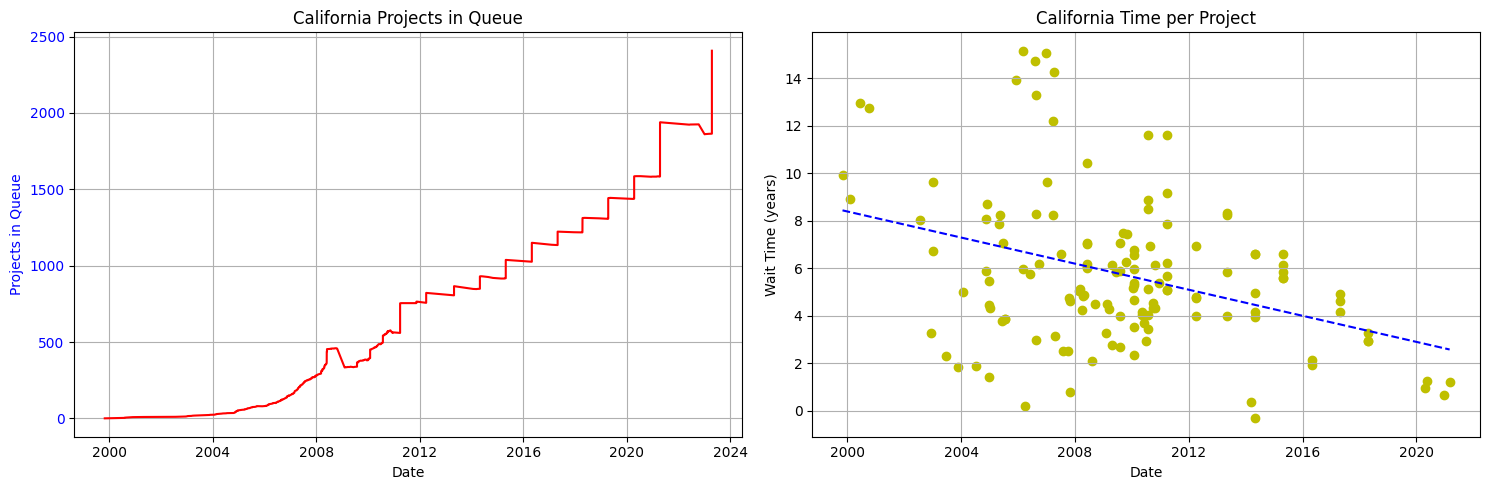

Total Completed Projects: 191
Total Withdrawn Projects: 45


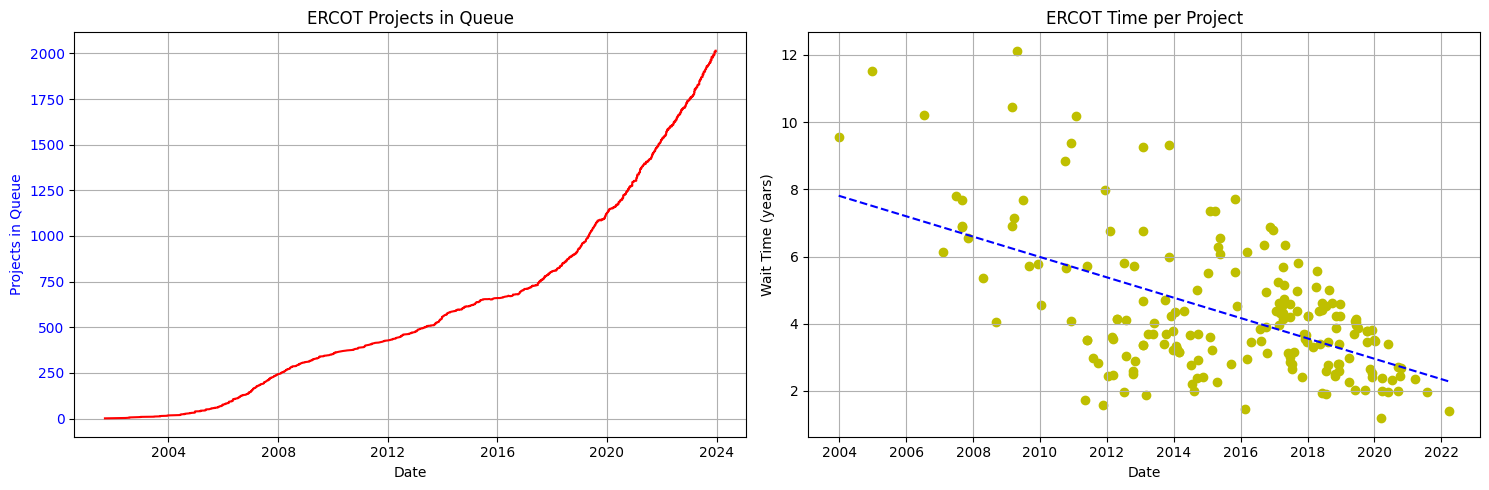

Total Completed Projects: 178
Total Withdrawn Projects: 92


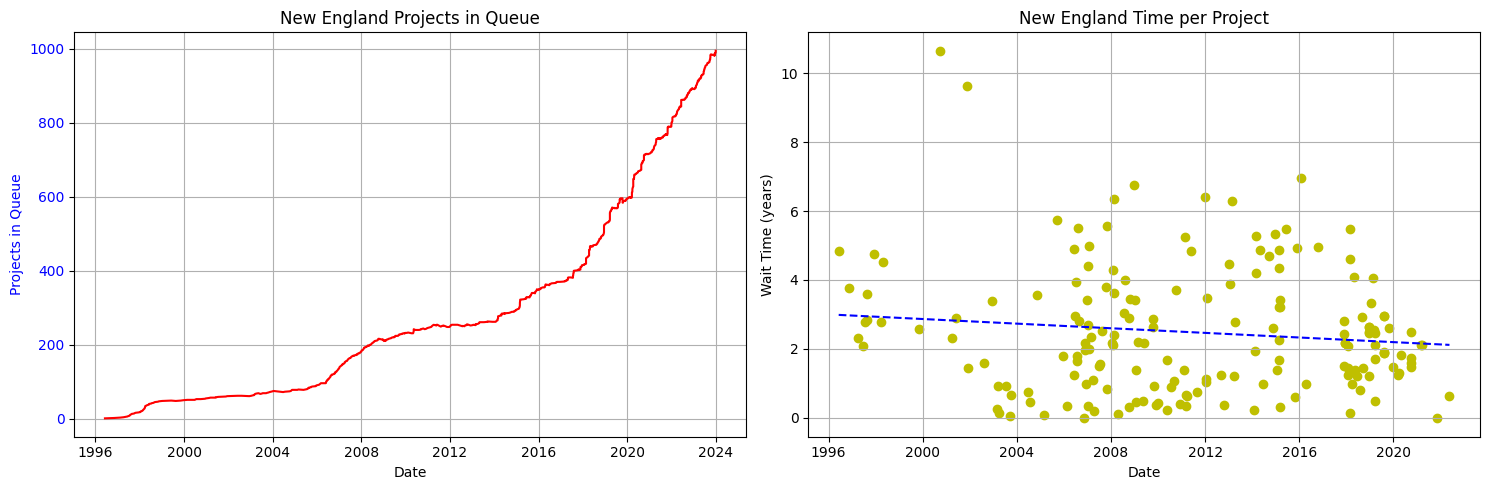

In [45]:
import matplotlib.pyplot as plt

iso_list = {
    "California": sorted_caiso,
    "ERCOT": sorted_ercot,
    # "PJM": sorted_pjm,
    "New England": sorted_iso_ne,
}
for name, iso in iso_list.items():
    completed_iso = iso[iso["on_date"].notna()]
    time_difference = calculate_difference(completed_iso)
    completed_dates = completed_iso["q_date"]
    queue = queue_length(iso)
    iso["queue"] = queue
    dates = iso["q_date"]

    # Create two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # First plot (Queue of Projects)
    ax1.plot(dates, queue, '-r', label="Projects in Queue")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Projects in Queue", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title(f"{name} Projects in Queue")
    ax1.grid()

    # Second plot (Wait Time per Project with Trend Line)
    ax2.scatter(completed_dates, time_difference, color='y', label="Wait Time per Project")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Wait Time (years)")
    ax2.tick_params(axis='y',)

    # Convert dates to numerical format for the trend line
    completed_dates_num = completed_dates.map(pd.Timestamp.toordinal)  # Convert dates to numbers
    coeffs = np.polyfit(completed_dates_num, time_difference, 1)  # Linear fit (degree=1)
    best_fit_line = np.polyval(coeffs, completed_dates_num)  # Compute best-fit values

    # Plot the best-fit line
    ax2.plot(completed_dates, best_fit_line, '--b', label="Trend Line")
    ax2.set_title(f"{name} Time per Project")
    ax2.grid()

    # Improve layout and show
    fig.tight_layout()
    plt.show()

### Linear Regression for Deployed  Power Plants

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


def linear_regression(iso, function,randomness=False):

    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)
    print(X_train)
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = linear_regression(iso,queue_by_category_and_capacity, randomness=False)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

     n_renewable  n_non_renewable  n_storage  mw_renewable  mw_non_renewable  \
7            1.0              6.0        1.0         150.0           3145.00   
55          22.0             26.0        1.0        4607.0           7062.00   
86          45.0             19.0        1.0        6272.2           4649.00   
47          16.0             24.0        1.0        3810.0           6766.00   
119         52.0             10.0        4.0        5891.0            872.51   
..           ...              ...        ...           ...               ...   
78          39.0             21.0        1.0        5954.2           5564.00   
16           4.0             12.0        1.0         546.0           4537.55   
129         25.0              5.0        8.0        3828.0            224.01   
56          23.0             26.0        1.0        4917.0           7062.00   
4            0.0              5.0        0.0           0.0           3080.00   

     mw_storage  
7          40.0  
55 

In [64]:
from sklearn.ensemble import RandomForestRegressor


def random_forests(iso,function,randomness = False):

    X_train, X_test, y_train, y_test = data_split(iso ,function, randomness=randomness)
    regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)
    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = random_forests(iso,queue_by_category_and_capacity,randomness=False)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

R^2 Performance on seen data for Caiso :0.8096998911568185 

R^2 Performance on unseen data for Caiso :-0.2517414837324776 

R^2 Performance on seen data for Ercot :0.857246611798232 

R^2 Performance on unseen data for Ercot :0.13572702099212752 

R^2 Performance on seen data for NE :-1.9381501976667437e-06 

R^2 Performance on unseen data for NE :-0.09121867141200735 



include queue times, in the previous 4 or 5 projects

In [48]:
from sklearn.tree import DecisionTreeRegressor


def decision_tree(iso,function, randomness = False):
    """Train and evaluate a Decision Tree Regressor on the given dataset."""

    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    regressor = DecisionTreeRegressor()

    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)

    r_2_seen = r2_score(y_train, y_pred_train)
    r2_unseen_data = r2_score(y_test, y_pred)

    return r_2_seen, r2_unseen_data


for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = decision_tree(iso,queue_by_category, randomness=True)
    print(f"R^2 Performance on seen data for {name} :{seen} \n")
    print(f"R^2 Performance on unseen data for {name} :{unseen} \n")

R^2 Performance on seen data for Caiso :0.9455822152181185 

R^2 Performance on unseen data for Caiso :-1.0151344992861966 

R^2 Performance on seen data for Ercot :0.9388005043802867 

R^2 Performance on unseen data for Ercot :-0.803419265147818 

R^2 Performance on seen data for NE :0.0 

R^2 Performance on unseen data for NE :-0.1338876908166211 



In [49]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

def xgboost_cv(iso, function, randomness=False):
    X_train, X_test, y_train, y_test = data_split(iso, function, randomness=randomness)

    # Convert data to DMatrix format (XGBoost optimized data structure)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define initial parameters
    params = {
        "max_depth": 5,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "seed": 42
    }

    # Perform cross-validation to determine optimal n_estimators
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=300,   # Max rounds
        nfold=5,               # 5-fold cross-validation
        metrics="rmse",        # Metric to evaluate
        early_stopping_rounds=10, # Stop if no improvement in 10 rounds
        verbose_eval=False
    )

    best_n_estimators = len(cv_results)  # Optimal number of boosting rounds

    # Train final model with optimal n_estimators
    best_xgb_model = XGBRegressor(n_estimators=best_n_estimators, **params)
    best_xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_xgb_model.predict(X_test)
    y_pred_train = best_xgb_model.predict(X_train)

    # Evaluate model performance
    r2_seen = r2_score(y_train, y_pred_train)
    r2_unseen = r2_score(y_test, y_pred)

    return r2_seen, r2_unseen

# Run the model for different datasets
for name, iso in {
    "Caiso": sorted_caiso,
    "Ercot": sorted_ercot,
    "NE": sorted_iso_ne,
}.items():
    seen, unseen = xgboost_cv(iso, queue_by_category, randomness=False)
    print(f"R^2 Performance on seen data for {name}: {seen:.4f}")
    print(f"R^2 Performance on unseen data for {name}: {unseen:.4f}\n")


R^2 Performance on seen data for Caiso: 0.4796
R^2 Performance on unseen data for Caiso: -0.0685

R^2 Performance on seen data for Ercot: 0.4838
R^2 Performance on unseen data for Ercot: 0.3381

R^2 Performance on seen data for NE: -0.0001
R^2 Performance on unseen data for NE: -0.0445



# Autoregressive model 

Autoregressive (AR) models are a type of time series model that predict future values based on past observations of the same variable.
$$ Y_t = \beta_0 + \beta_1Y_{t-1}+ \epsilon$$
The example above is order 1, an autoregressive model of order n is expressed as the following:
$$ Y_t = \beta_0 + \beta_1Y_{t-1}+ ...+ \beta _nY_{t-n} +\epsilon$$
Autoregressive models require the time series to be stationary, which means there's constant mean and variance over time (which I don't applies to our case). If the data is not stationary, differencing is required.
There are a couple of easy ways to test whether or not a time series is stationary or not:
 - 1) Augmented Dickey-Fueler 
    - Checks if the time series has a unit root ...
Differencing means subtracting the previous value

useful link: https://developer.ibm.com/tutorials/awb-creating-autoregressive-models-in-python/

In [51]:
from statsmodels.tsa.stattools import adfuller

X_train, X_test, y_train, y_test = data_split(iso, option=2, randomness=False)

rows, cols = X_train.shape
for column in range(cols):
    result = adfuller(X_train[:,column])
    print(f"{column}: p-value = {result[1]:.5f}")

TypeError: data_split() got an unexpected keyword argument 'option'

# Option 4

Combining autoregressive model with complex queue

Take a common enough resource type that is common across all isos and then perform the same regression and see if we can make a prediction.
The data set is all of the US, but for the autoregression it should only be for the respective iso.
Find ways to group resource type